In [39]:
!pip install opencv-python


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [40]:
import os 
import json
import time
import requests
import requests
from zipfile import ZipFile
import tarfile
from shutil import copyfile
from dataclasses import dataclass, field
import yaml
import glob
import random
import numpy as np
import pandas as pd
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt


In [41]:
def download_unzip(url,save_path):
    print("Downloading and extracting assets...",end="")
    file = requests.get(url)
    open(save_path,"wb").write(file.content)

    try:
        #Extract files
        if save_path.endswith(".tar"):
            with tarfile.open(save_path,"r") as tar:
                tar.extractall(os.path.split(save_path)[0])

        print("Done")
    except:
        print("Invalid file")


In [42]:
IMAGES_URL = r"http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
IMAGES_DIR = "Images"
IMAGES_TAR_PATH = os.path.join(os.getcwd(), f"{IMAGES_DIR}.tar")

ANNS_METADATA_URL = r"https://github.com/benjiebob/StanfordExtra/raw/master/keypoint_definitions.csv"
ANNS_METADATA = "keypoint_definitions.csv"

# Download if dataset does not exists.
if not os.path.exists(IMAGES_DIR):
    download_unzip(IMAGES_URL, IMAGES_TAR_PATH)
    os.remove(IMAGES_TAR_PATH)

if not os.path.isfile(ANNS_METADATA):
    download_unzip(ANNS_METADATA_URL, ANNS_METADATA)


In [43]:
ANN_PATH = "StanfordExtra_V12"
JSON_PATH = os.path.join(ANN_PATH, "StanfordExtra_v12.json")

with open(JSON_PATH) as file:
    json_data = json.load(file)

In [44]:
train_ids = np.load(os.path.join(ANN_PATH,
                                 "train_stanford_StanfordExtra_v12.npy"))
val_ids = np.load(os.path.join(ANN_PATH,
                               "test_stanford_StanfordExtra_v12.npy"))

print(f"Train Samples: {len(train_ids)}")
print(f"Validation Samples: {len(val_ids)}")

Train Samples: 6773
Validation Samples: 1703


In [45]:
print(type(train_ids))
print(train_ids)
train_json_data = []
for train_id in train_ids:
    train_json_data.append(json_data[train_id])

val_json_data = []
for val_id in val_ids:
    val_json_data.append(json_data[val_id])


<class 'numpy.ndarray'>
[ 910  917  920 ... 8977 9745 9742]


In [46]:
DATA_DIR = "animal-pose-data"

TRAIN_DIR         = f"train"
TRAIN_FOLDER_IMG    = f"images"
TRAIN_FOLDER_LABELS = f"labels"

TRAIN_IMG_PATH   = os.path.join(DATA_DIR, TRAIN_DIR, TRAIN_FOLDER_IMG)
TRAIN_LABEL_PATH = os.path.join(DATA_DIR, TRAIN_DIR, TRAIN_FOLDER_LABELS)

VALID_DIR           = f"valid"
VALID_FOLDER_IMG    = f"images"
VALID_FOLDER_LABELS = f"labels"

VALID_IMG_PATH   = os.path.join(DATA_DIR, VALID_DIR, VALID_FOLDER_IMG)
VALID_LABEL_PATH = os.path.join(DATA_DIR, VALID_DIR, VALID_FOLDER_LABELS)

os.makedirs(TRAIN_IMG_PATH, exist_ok=True)
os.makedirs(TRAIN_LABEL_PATH, exist_ok=True)
os.makedirs(VALID_IMG_PATH, exist_ok=True)
os.makedirs(VALID_LABEL_PATH, exist_ok=True)


In [47]:
train_json_data = []
for train_id in train_ids:
    train_json_data.append(json_data[train_id])

val_json_data = []
for val_id in val_ids:
    val_json_data.append(json_data[val_id])

In [48]:
for data in train_json_data:
    img_file = data["img_path"]
    filename = img_file.split("/")[-1]
    copyfile(os.path.join(IMAGES_DIR, img_file),
             os.path.join(TRAIN_IMG_PATH, filename))


for data in val_json_data:
    img_file = data["img_path"]
    filename = img_file.split("/")[-1]
    copyfile(os.path.join(IMAGES_DIR, img_file),
             os.path.join(VALID_IMG_PATH, filename))

In [49]:
CLASS_ID = 0

In [50]:
def create_yolo_boxes_kpts(img_size, boxes, lm_kpts):

    IMG_W, IMG_H = img_size
    # Modify kpts with visibilities as 1s to 2s.
    vis_ones = np.where(lm_kpts[:, -1] == 1.)
    lm_kpts[vis_ones, -1] = 2.

    # Normalizing factor for bboxes and kpts.
    res_box_array = np.array([IMG_W, IMG_H, IMG_W, IMG_H])
    res_lm_array = np.array([IMG_W, IMG_H])

    # Normalize landmarks in the range [0,1].
    norm_kps_per_img = lm_kpts.copy()
    norm_kps_per_img[:, :-1]  = norm_kps_per_img[:, :-1] / res_lm_array

    # Normalize bboxes in the range [0,1].
    norm_bbox_per_img = boxes / res_box_array

    # Create bboxes coordinates to YOLO.
    # x_c, y_c = x_min + bbox_w/2. , y_min + bbox_h/2.
    yolo_boxes = norm_bbox_per_img.copy()
    yolo_boxes[:2] = norm_bbox_per_img[:2] + norm_bbox_per_img[2:]/2.

    return yolo_boxes, norm_kps_per_img

In [51]:
def create_yolo_txt_files(json_data, LABEL_PATH):

    for data in json_data:

        IMAGE_ID = data["img_path"].split("/")[-1].split(".")[0]

        IMG_WIDTH, IMG_HEIGHT = data["img_width"], data["img_height"]

        landmark_kpts  = np.nan_to_num(np.array(data["joints"], dtype=np.float32))
        landmarks_bboxes = np.array(data["img_bbox"], dtype=np.float32)

        bboxes_yolo, kpts_yolo = create_yolo_boxes_kpts(
                                            (IMG_WIDTH, IMG_HEIGHT),
                                            landmarks_bboxes,
                                            landmark_kpts)

        TXT_FILE = IMAGE_ID+".txt"

        with open(os.path.join(LABEL_PATH, TXT_FILE), "w") as f:

            x_c_norm, y_c_norm, box_width_norm, box_height_norm = round(bboxes_yolo[0],5),\
                                                                  round(bboxes_yolo[1],5),\
                                                                  round(bboxes_yolo[2],5),\
                                                                  round(bboxes_yolo[3],5),\

            kps_flattend = [round(ele,5) for ele in kpts_yolo.flatten().tolist()]
            line = f"{CLASS_ID} {x_c_norm} {y_c_norm} {box_width_norm} {box_height_norm} "
            line+= " ".join(map(str, kps_flattend))
            f.write(line)

In [52]:
create_yolo_txt_files(train_json_data, TRAIN_LABEL_PATH)
create_yolo_txt_files(val_json_data, VALID_LABEL_PATH)

In [53]:
ann_meta_data = pd.read_csv("keypoint_definitions.csv")
COLORS = ann_meta_data["Hex colour"].values.tolist()

COLORS_RGB_MAP = []
for color in COLORS:
    R, G, B = int(color[:2], 16), int(color[2:4], 16), int(color[4:], 16)
    COLORS_RGB_MAP.append({color: (R,G,B)})

In [54]:
train_images = os.listdir(TRAIN_IMG_PATH)
valid_images = os.listdir(VALID_IMG_PATH)

print(f"Training images: {len(train_images)}, Validation Images: {len(valid_images)}")

Training images: 6773, Validation Images: 1703


In [55]:
def draw_landmarks(image, landmarks):

    radius = 5
    # Check if image width is greater than 1000 px.
    # To improve visualization.
    if (image.shape[1] > 1000):
        radius = 8

    for idx, kpt_data in enumerate(landmarks):

        loc_x, loc_y = kpt_data[:2].astype("int").tolist()
        color_id = list(COLORS_RGB_MAP[int(kpt_data[-1])].values())[0]

        cv2.circle(image,
                   (loc_x, loc_y),
                   radius,
                   color=color_id[::-1],
                   thickness=-1,
                   lineType=cv2.LINE_AA)

    return image

In [56]:
def draw_boxes(image, detections, class_name = "dog", score=None, color=(0,255,0)):

    font_size = 0.25 + 0.07 * min(image.shape[:2]) / 100
    font_size = max(font_size, 0.5)
    font_size = min(font_size, 0.8)
    text_offset = 3

    thickness = 2
    # Check if image width is greater than 1000 px.
    # To improve visualization.
    if (image.shape[1] > 1000):
        thickness = 10

    xmin, ymin, xmax, ymax = detections[:4].astype("int").tolist()
    conf = round(float(detections[-1]),2)
    cv2.rectangle(image,
                  (xmin, ymin),
                  (xmax, ymax),
                  color=(0,255,0),
                  thickness=thickness,
                  lineType=cv2.LINE_AA)

    display_text = f"{class_name}"

    if score is not None:
        display_text+=f": {score:.2f}"

    (text_width, text_height), _ = cv2.getTextSize(display_text,
                                                   cv2.FONT_HERSHEY_SIMPLEX,
                                                   font_size, 2)

    cv2.rectangle(image,
                      (xmin, ymin),
                      (xmin + text_width + text_offset, ymin - text_height - int(15 * font_size)),
                      color=color, thickness=-1)

    image = cv2.putText(
                    image,
                    display_text,
                    (xmin + text_offset, ymin - int(10 * font_size)),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    font_size,
                    (0, 0, 0),
                    2, lineType=cv2.LINE_AA,
                )

    return image

In [57]:
def visualize_annotations(image, box_data, keypoints_data):

    image = image.copy()

    shape_multiplier = np.array(image.shape[:2][::-1]) # (W, H).
    # Final absolute coordinates (xmin, ymin, xmax, ymax).
    denorm_boxes = np.zeros_like(box_data)

    # De-normalize center coordinates from YOLO to (xmin, ymin).
    denorm_boxes[:, :2] = (shape_multiplier/2.) * (2*box_data[:,:2] - box_data[:,2:])

    # De-normalize width and height from YOLO to (xmax, ymax).
    denorm_boxes[:, 2:] = denorm_boxes[:,:2] + box_data[:,2:]*shape_multiplier

    for boxes, kpts in zip(denorm_boxes, keypoints_data):
        # De-normalize landmark coordinates.
        kpts[:, :2]*= shape_multiplier
        image = draw_boxes(image, boxes)
        image = draw_landmarks(image, kpts)

    return image

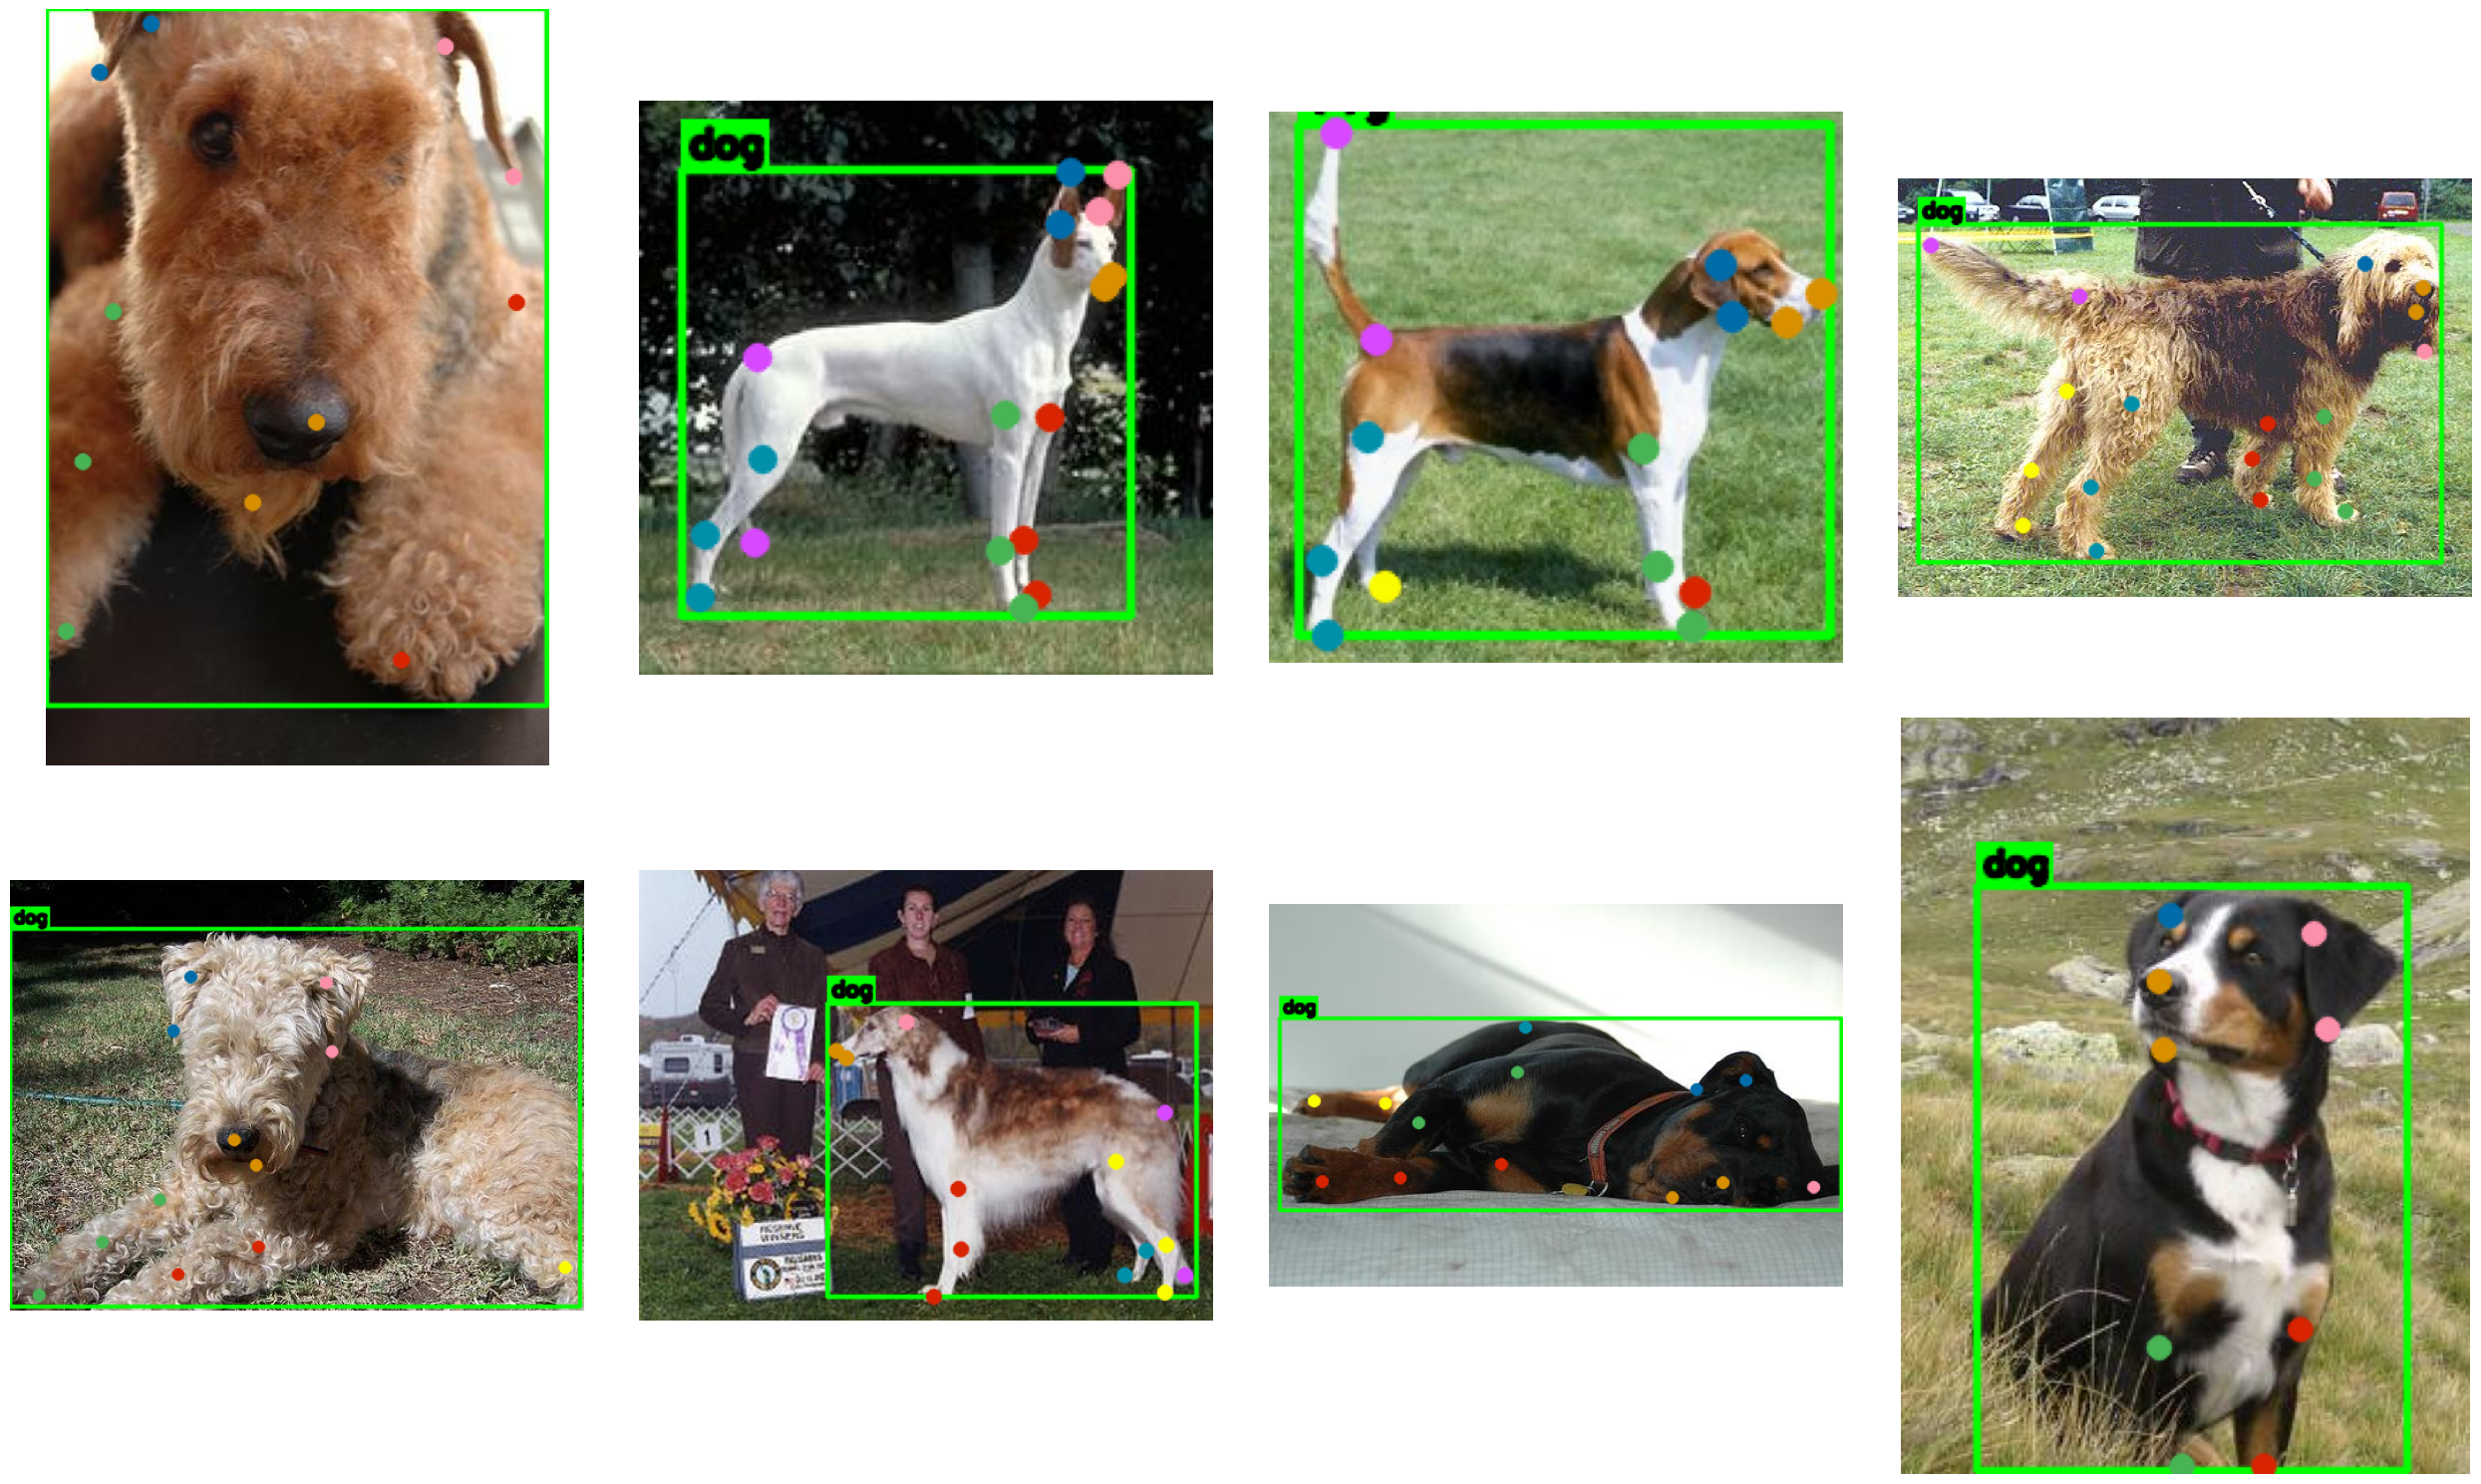

In [58]:
IMAGE_FILES = os.listdir(TRAIN_IMG_PATH)
NUM_LANDMARKS = 24

num_samples = 8
num_rows = 2
num_cols = num_samples//num_rows

fig, ax = plt.subplots(
        nrows=num_rows,
        ncols=num_cols,
        figsize=(25, 15),
    )

random.seed(45)
random.shuffle(IMAGE_FILES)

for idx, (file, axis) in enumerate(zip(IMAGE_FILES[:num_samples], ax.flat)):

    image = cv2.imread(os.path.join(TRAIN_IMG_PATH, file))

    # Obtain the txt file for the corresponding image file.
    filename = file.split(".")[0]
    # Split each object instance in separate lists.
    with open(os.path.join(TRAIN_LABEL_PATH, filename+".txt"), "r") as file:
        label_data = [x.split() for x in file.read().strip().splitlines() if len(x)]

    label_data = np.array(label_data, dtype=np.float32)

    # YOLO BBox instances in [x-center, y-center, width, height] in normalized form.
    box_instances = label_data[:,1:5]
    # Shape: (N, 4), where, N = #instances per-image

    # Kpt instances.
    # Filter keypoints based on visibility.
    instance_kpts = []
    kpts_data = label_data[:,5:].reshape(-1, NUM_LANDMARKS, 3)

    for inst_kpt in kpts_data:
        vis_ids = np.where(inst_kpt[:, -1]>0.)[0]
        vis_kpts = inst_kpt[vis_ids][:,:2]
        vis_kpts = np.concatenate([vis_kpts, np.expand_dims(vis_ids, axis=-1)], axis=-1)
        instance_kpts.append(vis_kpts)

    image_ann = visualize_annotations(image, box_instances, instance_kpts)
    axis.imshow(image_ann[...,::-1])
    axis.axis("off")


plt.tight_layout(h_pad=4., w_pad=4.)
plt.show();

In [59]:
@dataclass(frozen=True)
class TrainingConfig:
    DATASET_YAML:   str = "animal-keypoints.yaml"
    MODEL:          str = "yolov8m-pose.pt"
    EPOCHS:         int = 100
    KPT_SHAPE:    tuple = (24,3)
    PROJECT:        str = "Animal_Keypoints"
    NAME:           str = f"{MODEL.split('.')[0]}_{EPOCHS}_epochs"
    CLASSES_DICT:  dict = field(default_factory = lambda:{0 : "dog"})

In [60]:
@dataclass(frozen=True)
class DatasetConfig:
    IMAGE_SIZE:    int   = 640
    BATCH_SIZE:    int   = 16
    CLOSE_MOSAIC:  int   = 10
    MOSAIC:        float = 0.4
    FLIP_LR:       float = 0.0 # Turn off horizontal flip.

In [61]:
train_config = TrainingConfig()
data_config = DatasetConfig()

In [62]:
current_dir = os.getcwd()

data_dict = dict(
                path      = os.path.join(current_dir, DATA_DIR),
                train     = os.path.join(TRAIN_DIR, TRAIN_FOLDER_IMG),
                val       = os.path.join(VALID_DIR, VALID_FOLDER_IMG),
                names     = train_config.CLASSES_DICT,
                kpt_shape = list(train_config.KPT_SHAPE),
               )

with open(train_config.DATASET_YAML, "w") as config_file:
    yaml.dump(data_dict, config_file)